Beginner-Friendly Political Sentiment Analysis Project

In [29]:
# 1) Imports & config
import re
from collections import Counter
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from IPython.display import display, HTML

sns.set(style="whitegrid")
pd.set_option('display.max_colwidth', 300)

# EDIT THIS: path to your CSV
INPUT_PATH = r"C:\Users\HP\OneDrive\Desktop\test (1).csv"
CLEANED_PATH = r"C:\Users\HP\OneDrive\Desktop\test_2024_cleaned_pandas.csv"
SAMPLE_PREVIEW = 5


In [30]:
# 2) Simple cleaning helpers (only regex + basic python)
url_re = re.compile(r'https?://\S+|www\.\S+')
mention_re = re.compile(r'@\w+')
hashtag_re = re.compile(r'#(\w+)')
html_re = re.compile(r'<.*?>')
multi_space_re = re.compile(r'\s+')
keep_chars_re = re.compile(r'[^a-zA-Z0-9\s]')  # remove punctuation except alnum & spaces

def simple_clean(text, remove_urls=True, remove_mentions=True,
                 keep_hashtag_text=True, lowercase=True):
    """Very simple safe cleaning for social media text."""
    if pd.isna(text):
        return ""
    s = str(text)
    # drop HTML tags
    s = html_re.sub(' ', s)
    if remove_urls:
        s = url_re.sub(' ', s)
    if remove_mentions:
        s = mention_re.sub(' ', s)
    if keep_hashtag_text:
        s = hashtag_re.sub(r'\1', s)   # "#tag" -> "tag"
    else:
        s = hashtag_re.sub(' ', s)
    # remove other punctuation
    s = keep_chars_re.sub(' ', s)
    s = multi_space_re.sub(' ', s).strip()
    if lowercase:
        s = s.lower()
    return s

def simple_tokenize(text):
    return [w for w in str(text).split() if w]


In [31]:
# 3) Load CSV & quick preview
assert Path(INPUT_PATH).exists(), f"File not found: {INPUT_PATH}"
df = pd.read_csv(INPUT_PATH, low_memory=False)
print("Original shape:", df.shape)
display(df.head(SAMPLE_PREVIEW))
print("\nColumns:\n", df.columns.tolist())


Original shape: (50, 9)


,tweet_id,user_handle,timestamp,tweet_text,candidate,party,retweets,likes,sentiment
0,501,@user1068,11-02-2025 08:30,Kamala Harris's new policy on education reform is impressive.,Kamala Harris,Democratic Party,85,320,positive
1,502,@politicsNew2,11-02-2025 09:15,Donald Trump's latest speech on the economy was well-received.,Donald Trump,Republican Party,100,450,positive
2,503,@greenVisionary2,11-02-2025 10:05,Jill Stein's environmental policies are a step in the right direction.,Jill Stein,Green Party,60,200,positive
3,504,@indieWatcher2,11-02-2025 11:25,Robert Kennedy's independent run brings fresh perspectives to the race.,Robert Kennedy,Independent,30,120,neutral
4,505,@libertyFan4,11-02-2025 12:40,Chase Oliver's stance on gun rights is unwavering.,Chase Oliver,Libertarian Party,50,160,positive



Columns:
 ['tweet_id', 'user_handle', 'timestamp', 'tweet_text', 'candidate', 'party', 'retweets', 'likes', 'sentiment']


In [32]:
# 4) Auto-detect text / date / id / label columns (common names)
TEXT_CANDIDATES = ["text","tweet","content","post","tweet_text","status"]
DATE_CANDIDATES = ["created_at","timestamp","date","time","created"]
ID_CANDIDATES = ["id","tweet_id","status_id"]
LABEL_CANDIDATES = ["sentiment","label","target","class","annotation"]

def find_column(cols, candidates):
    lower = {c.lower(): c for c in cols}
    for cand in candidates:
        if cand in cols:
            return cand
        if cand.lower() in lower:
            return lower[cand.lower()]
    return None

text_col = find_column(df.columns.tolist(), TEXT_CANDIDATES)
date_col = find_column(df.columns.tolist(), DATE_CANDIDATES)
id_col = find_column(df.columns.tolist(), ID_CANDIDATES)
label_col = find_column(df.columns.tolist(), LABEL_CANDIDATES)

print("Detected -> text:", text_col, "date:", date_col, "id:", id_col, "label:", label_col)

if text_col is None:
    raise ValueError("Couldn't find a text column automatically. Inspect df.columns and set text_col manually.")


Detected -> text: tweet_text date: timestamp id: tweet_id label: sentiment


In [33]:
# 5) Keep essential columns, rename, and do cleaning
keep = []
for c in (id_col, date_col, text_col):
    if c and c not in keep:
        keep.append(c)
if label_col and label_col not in keep:
    keep.append(label_col)

df = df[keep].copy()
df = df.rename(columns={text_col: 'text'})
if id_col:
    df = df.rename(columns={id_col: 'id'})
if date_col:
    df = df.rename(columns={date_col: 'created_at'})

# Apply cleaning (vectorized/pandas)
df['clean_text'] = df['text'].astype(str).apply(simple_clean)
df['clean_len'] = df['clean_text'].str.len().fillna(0)
before = len(df)
df = df[df['clean_len'] >= 3].reset_index(drop=True)   # drop extremely short
print(f"Dropped {before - len(df)} very short rows; remaining {len(df)}")
display(df.head(SAMPLE_PREVIEW))


Dropped 0 very short rows; remaining 50


,id,created_at,text,sentiment,clean_text,clean_len
0,501,11-02-2025 08:30,Kamala Harris's new policy on education reform is impressive.,positive,kamala harris s new policy on education reform is impressive,60
1,502,11-02-2025 09:15,Donald Trump's latest speech on the economy was well-received.,positive,donald trump s latest speech on the economy was well received,61
2,503,11-02-2025 10:05,Jill Stein's environmental policies are a step in the right direction.,positive,jill stein s environmental policies are a step in the right direction,69
3,504,11-02-2025 11:25,Robert Kennedy's independent run brings fresh perspectives to the race.,neutral,robert kennedy s independent run brings fresh perspectives to the race,70
4,505,11-02-2025 12:40,Chase Oliver's stance on gun rights is unwavering.,positive,chase oliver s stance on gun rights is unwavering,49


In [34]:
# 6) Parse dates (if exists) and derive simple time columns
if 'created_at' in df.columns:
    # try pandas to_datetime
    df['created_at'] = pd.to_datetime(df['created_at'], errors='coerce')

    df['date'] = df['created_at'].dt.date
    df['hour'] = df['created_at'].dt.hour
    df['weekday'] = df['created_at'].dt.day_name()
    print("Date parsing done. Sample:")
    display(df[['created_at','date','hour','weekday']].head(3))
else:
    print("No date column detected; continuing without time features.")


Date parsing done. Sample:


,created_at,date,hour,weekday
0,2025-11-02 08:30:00,2025-11-02,8.0,Sunday
1,2025-11-02 09:15:00,2025-11-02,9.0,Sunday
2,2025-11-02 10:05:00,2025-11-02,10.0,Sunday


In [35]:
# 7) Basic EDA: totals, sample posts, label distribution if present
print("Total cleaned posts:", len(df))
display(df[['text','clean_text']].head(6))

# Label distribution
if label_col:
    print("Label column found:", label_col)
    display(df[label_col].value_counts().rename_axis(label_col).reset_index(name='count'))
else:
    print("No label column found. We'll use a simple lexicon-based predictor next.")


Total cleaned posts: 50


,text,clean_text
0,Kamala Harris's new policy on education reform is impressive.,kamala harris s new policy on education reform is impressive
1,Donald Trump's latest speech on the economy was well-received.,donald trump s latest speech on the economy was well received
2,Jill Stein's environmental policies are a step in the right direction.,jill stein s environmental policies are a step in the right direction
3,Robert Kennedy's independent run brings fresh perspectives to the race.,robert kennedy s independent run brings fresh perspectives to the race
4,Chase Oliver's stance on gun rights is unwavering.,chase oliver s stance on gun rights is unwavering
5,Kamala Harris is making strides in healthcare accessibility.,kamala harris is making strides in healthcare accessibility


Label column found: sentiment


,sentiment,count
0,positive,34
1,neutral,13
2,negative,3


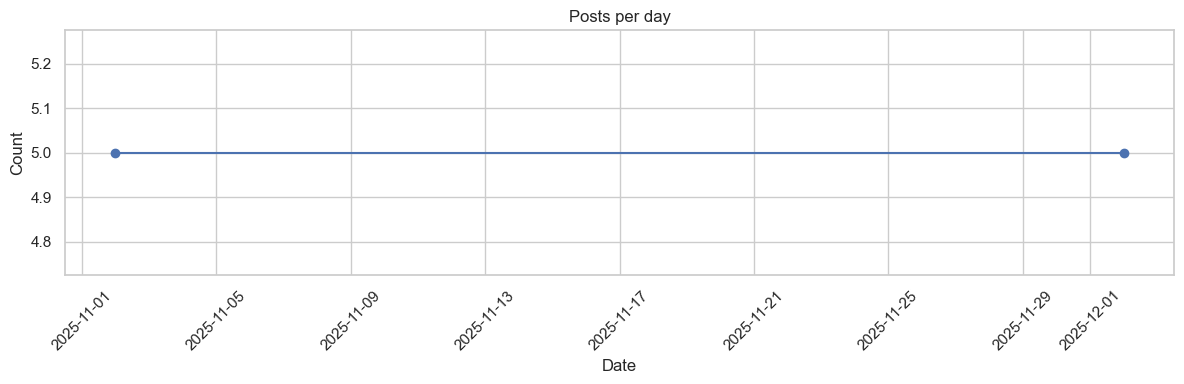

In [36]:
# 8) Posts over time plot (daily) — if date present
if 'date' in df.columns:
    counts = df.groupby('date').size().rename('count').reset_index()
    plt.figure(figsize=(12,4))
    plt.plot(counts['date'], counts['count'], marker='o', linestyle='-')
    plt.title('Posts per day')
    plt.xlabel('Date'); plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
else:
    print("No date column to plot time series.")


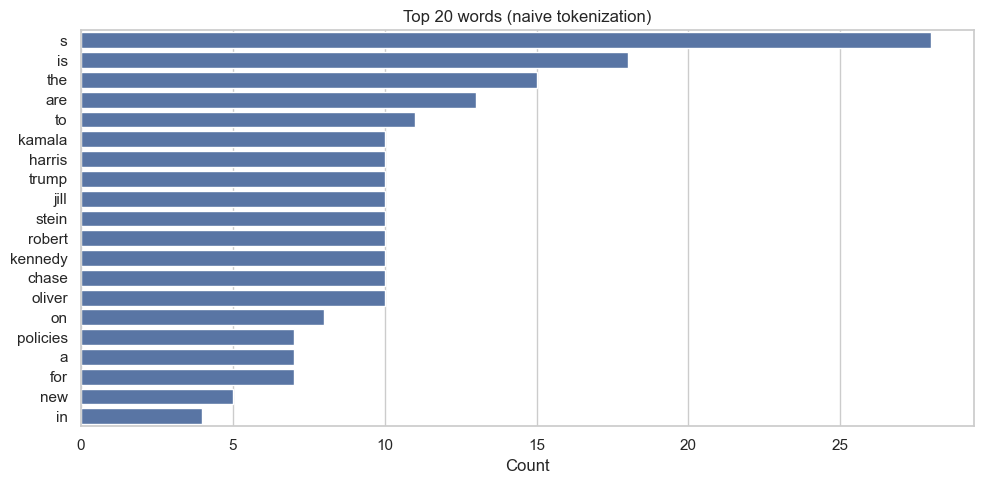

In [37]:
# 9) Top words (naive) and bar chart of top 20 words
def top_n_words(series, n=20):
    c = Counter()
    for s in series.dropna().astype(str):
        c.update(simple_tokenize(s))
    return c.most_common(n)

top20 = top_n_words(df['clean_text'], 20)
words, counts = zip(*top20) if top20 else ([],[])
plt.figure(figsize=(10,5))
sns.barplot(x=list(counts), y=list(words))
plt.title('Top 20 words (naive tokenization)')
plt.xlabel('Count'); plt.tight_layout()
plt.show()


In [38]:
# 10) Top hashtags: extract tokens that started with '#' before cleaning by checking original text
def extract_hashtags(text):
    if pd.isna(text): return []
    return re.findall(r'#(\w+)', str(text))

all_hashtags = Counter()
for t in df['text'].astype(str):
    all_hashtags.update(extract_hashtags(t.lower()))

top_hashtags = all_hashtags.most_common(20)
if top_hashtags:
    tags, tcounts = zip(*top_hashtags)
    plt.figure(figsize=(10,5))
    sns.barplot(x=list(tcounts), y=list(tags))
    plt.title('Top hashtags (original text)')
    plt.xlabel('Count'); plt.tight_layout()
    plt.show()
else:
    print("No hashtags found in original text.")


No hashtags found in original text.


In [39]:
# 11) Simple lexicon-based sentiment (beginner friendly)
# Small starter lists — expand these later to improve accuracy
positive_words = set("good great excellent amazing love support win strong happy positive progress honest hope".split())
negative_words = set("bad terrible awful hate corrupt fail weak angry dishonest scandal crisis loss problem".split())

def lexicon_score(text):
    toks = simple_tokenize(text)
    pos = sum(1 for w in toks if w in positive_words)
    neg = sum(1 for w in toks if w in negative_words)
    return pos - neg

def lexicon_label(text, neutral_threshold=0):
    s = lexicon_score(text)
    if s > neutral_threshold:
        return 'positive'
    elif s < -neutral_threshold:
        return 'negative'
    else:
        return 'neutral'

df['lex_score'] = df['clean_text'].apply(lexicon_score)
df['lex_label'] = df['clean_text'].apply(lambda t: lexicon_label(t, neutral_threshold=0))

display(df[['clean_text','lex_score','lex_label']].head(10))


,clean_text,lex_score,lex_label
0,kamala harris s new policy on education reform is impressive,0,neutral
1,donald trump s latest speech on the economy was well received,0,neutral
2,jill stein s environmental policies are a step in the right direction,0,neutral
3,robert kennedy s independent run brings fresh perspectives to the race,0,neutral
4,chase oliver s stance on gun rights is unwavering,0,neutral
5,kamala harris is making strides in healthcare accessibility,0,neutral
6,trump s tax cuts are benefiting small businesses,0,neutral
7,jill stein promotes the adoption of electric vehicles to combat pollution,0,neutral
8,robert kennedy s policies blend diverse ideological perspectives,0,neutral
9,chase oliver s economic plans focus on maximizing individual choice,0,neutral


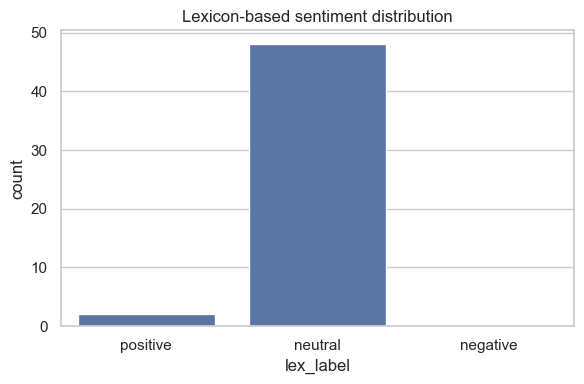

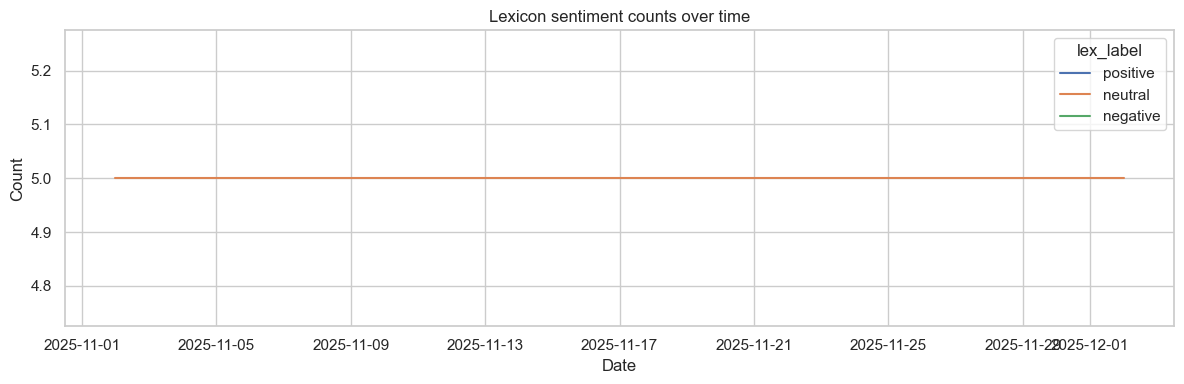

In [40]:
# 12) Visualize lexicon results
plt.figure(figsize=(6,4))
order = ['positive','neutral','negative']
sns.countplot(x='lex_label', data=df, order=order)
plt.title('Lexicon-based sentiment distribution')
plt.tight_layout()
plt.show()

# If date available: show lexicon counts over time
if 'date' in df.columns:
    tmp = df.groupby(['date','lex_label']).size().unstack(fill_value=0).reindex(columns=order)
    tmp.plot(kind='line', figsize=(12,4))
    plt.title('Lexicon sentiment counts over time')
    plt.xlabel('Date'); plt.ylabel('Count'); plt.tight_layout()
    plt.show()


In [41]:
# 13) If dataset has a true label column, compute simple accuracy / confusion table
if label_col:
    # normalize true labels to 'positive','negative','neutral' simple set
    def normalize_label(x):
        x = str(x).lower()
        if 'pos' in x or 'positive' in x or 'pro' in x or 'support' in x:
            return 'positive'
        if 'neg' in x or 'negative' in x or 'anti' in x or 'oppose' in x:
            return 'negative'
        if 'neu' in x or 'neutral' in x:
            return 'neutral'
        return x

    df['true_simple'] = df[label_col].apply(normalize_label)
    eval_df = df[df['true_simple'].isin(['positive','negative','neutral'])].copy()
    if len(eval_df) > 0:
        matched = (eval_df['true_simple'] == eval_df['lex_label']).sum()
        total = len(eval_df)
        acc = matched / total
        print(f"Lexicon accuracy on comparable labelled rows: {matched}/{total} = {acc:.3f}")
        conf = pd.crosstab(eval_df['true_simple'], eval_df['lex_label'], margins=True)
        display(conf)
    else:
        print("Label column present but not in expected format for comparison.")
else:
    print("No true labels to compare with.")


Lexicon accuracy on comparable labelled rows: 15/50 = 0.300


lex_label,neutral,positive,All
true_simple,,,
negative,3,0,3
neutral,13,0,13
positive,32,2,34
All,48,2,50


#EXAMPLE (RESULT)

In [42]:
# 14) Inspect misclassifications (if labels present) — show examples
if label_col and 'true_simple' in df.columns:
    mis = df[(df['true_simple'].isin(['positive','negative','neutral'])) & (df['true_simple'] != df['lex_label'])]
    print("Number of mismatches:", len(mis))
    display(mis[['text','clean_text','true_simple','lex_label']].sample(n=min(8,len(mis)), random_state=42))


Number of mismatches: 35


,text,clean_text,true_simple,lex_label
36,Kamala Harris is rolling out new education reforms aimed at inclusivity.,kamala harris is rolling out new education reforms aimed at inclusivity,positive,neutral
17,Jill Stein promotes the use of electric vehicles to lower emissions.,jill stein promotes the use of electric vehicles to lower emissions,positive,neutral
34,Chase Oliver's commitment to liberty is resonating with many voters.,chase oliver s commitment to liberty is resonating with many voters,positive,neutral
30,Kamala Harris's climate change initiatives are setting new goals.,kamala harris s climate change initiatives are setting new goals,positive,neutral
20,Kamala Harris continues to inspire with her leadership.,kamala harris continues to inspire with her leadership,positive,neutral
40,Kamala Harris's healthcare policies are making significant impacts.,kamala harris s healthcare policies are making significant impacts,positive,neutral
27,Jill Stein is advocating for zero-waste cities nationwide.,jill stein is advocating for zero waste cities nationwide,positive,neutral
16,Trump's tax cuts are seen as favoring the wealthy.,trump s tax cuts are seen as favoring the wealthy,negative,neutral


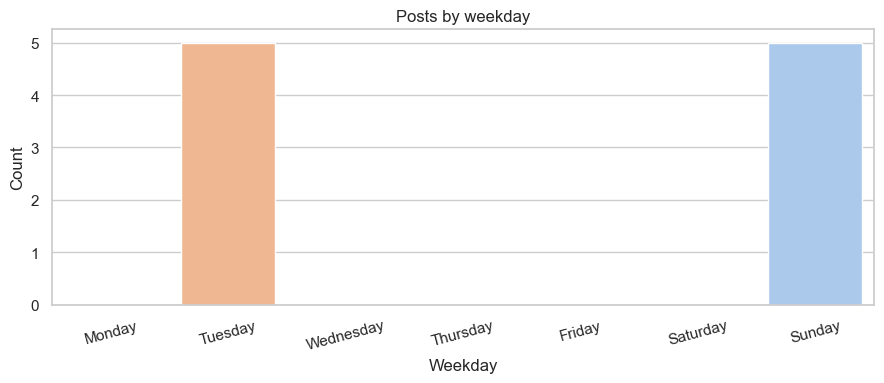

In [47]:
# Posts by weekday (fixed for seaborn FutureWarning)
if 'weekday' not in df.columns and 'created_at' in df.columns:
    df['weekday'] = df['created_at'].dt.day_name()

if 'weekday' in df.columns:
    order = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
    plt.figure(figsize=(9,4))
    sns.countplot(
        x='weekday',
        data=df,
        order=order,
        hue='weekday',      # required for palette
        palette='pastel',
        legend=False        # hides redundant legend
    )
    plt.title('Posts by weekday')
    plt.xlabel('Weekday'); plt.ylabel('Count')
    plt.xticks(rotation=15)
    plt.tight_layout()
    plt.show()
else:
    print("Skip weekday plot: no 'weekday' or 'created_at'")



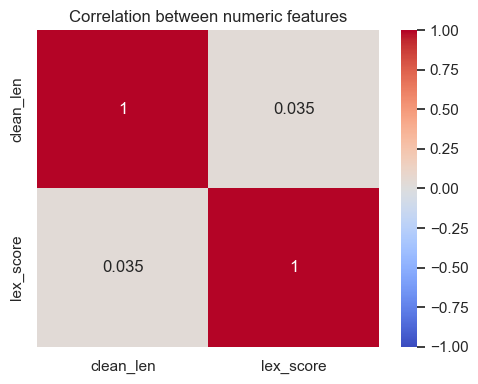

In [45]:
# Correlation heatmap for numeric features (clean_len, lex_score)
numeric_cols = [c for c in ['clean_len','lex_score'] if c in df.columns]
if numeric_cols:
    corr = df[numeric_cols].corr()
    plt.figure(figsize=(5,4))
    sns.heatmap(corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
    plt.title('Correlation between numeric features')
    plt.tight_layout()
    plt.show()
else:
    print("Skip heatmap: no numeric features available")
